refer to the slides for an intuitive math explanation of diffusion models
https://www.figma.com/file/qGZTQDS2nBG9797921eM48/diffusion?node-id=0%3A1&t=aaps3X8j0WiVDyNk-1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch import nn
from torch.nn import Module
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(0)

In [18]:
# global variables

device = "cuda" if torch.cuda.is_available() else "cpu"

T = 1000 # number of steps the diffusion model takes
BATCH_SIZE = 32 # for the data loader

betas = torch.linspace(0.0001, 0.02, T) # variance scheduler, values taken from official implementation
alphas = 1 - betas
alpha_bars = [alphas[0]]
for alpha in alphas[1:]: alpha_bars.append(alpha*alpha_bars[-1])

# check if alpha bars is correct
# print(betas, alphas, alpha_bars)
# checked

In [10]:
# convenience function to show 
def show_tensor(tensor):
  plt.imshow(tensor[0, 0].cpu().detach().numpy(), cmap='gray')
  plt.show()

In [11]:
device

'cuda'

In [19]:
dataset = datasets.MNIST('mnist_data', download=True, train=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(), # convert image to PyTorch tensor
                                    transforms.Lambda(lambda t: 2*t - 1)
                                ]))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

torch.Size([128, 1, 28, 28]) tensor([6, 8, 8, 7, 8, 0, 0, 5, 6, 0, 0, 3, 5, 8, 1, 6, 2, 4, 1, 4, 9, 4, 3, 4,
        1, 4, 8, 7, 6, 3, 1, 8, 4, 4, 6, 2, 4, 2, 9, 5, 7, 8, 0, 7, 5, 5, 9, 3,
        6, 6, 4, 6, 7, 8, 3, 6, 2, 2, 7, 7, 2, 4, 4, 9, 9, 5, 2, 2, 9, 0, 9, 4,
        6, 5, 8, 5, 7, 1, 4, 2, 1, 8, 8, 6, 9, 7, 8, 0, 0, 8, 8, 6, 5, 0, 6, 9,
        7, 4, 1, 8, 1, 4, 0, 3, 5, 4, 6, 8, 1, 8, 7, 5, 5, 6, 0, 6, 5, 4, 9, 2,
        6, 0, 3, 1, 5, 8, 4, 0])


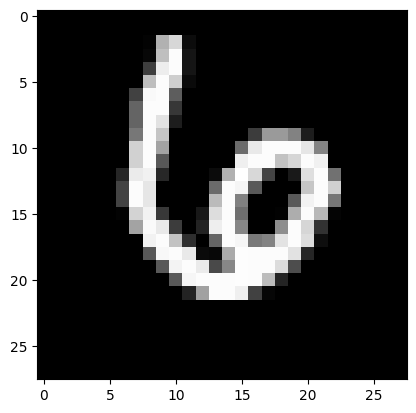

In [7]:
images, label = next(dataloader)
print(f"input image is of shape {images.shape}")
plt.imshow(images[0,0], cmap='gray')
plt.show()

7


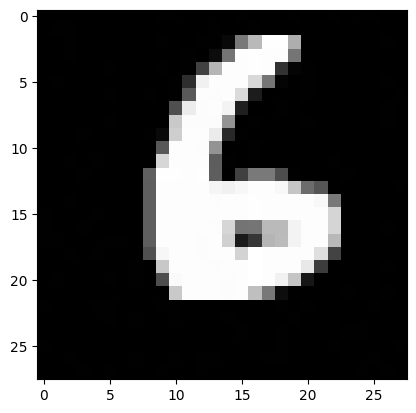

In [8]:
# operates on a batch of images
# introduces noise into the input image
# generates x_t from x_0 in literature vocab
def forward_pass(x_0, eta, t):
  alpha_bar_t = torch.tensor([alpha_bars[t_i] for t_i in t])[:, None, None, None]
  return torch.sqrt(alpha_bar_t)*x_0 + (1-alpha_bar_t)*eta

# check the degradation for different t values
# checked
x = images[33:40]
eta = torch.randn_like(x)
t = torch.randint(0, T, (len(x),)).long()
t[0] = 9

degraded_images = forward_pass(x, eta, t)
print(len(degraded_images))
show_tensor(degraded_images)

In [36]:
# model

# pytorch follows N C H W

class Swish(Module):

  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.nn.LeakyReLU()(x)

class TimeEmbedding(Module):

  """
  Just like positional encoder in transformers

  time_channels is an arbritary size
  The generated embedding will be fed to a feed forward network to 
  match the shape of the intermediate tensor

  output shape = [batch_size, time_channels]
  """

  def __init__(self, time_channels):
    super().__init__()
    self.d = time_channels//8
    self.swish = Swish()
    self.linear_1 = nn.Linear(time_channels//4, time_channels)
    self.linear_2 = nn.Linear(time_channels, time_channels)

  def forward(self, t):

    # generate sin, cos time information

    factor = -math.log(1e5)/(self.d-1)
    embeddings = torch.exp(torch.arange(self.d)*factor).to(device)
    # t.shape = [batch_size, 1]
    # embeddings.shape = [time_channels//8]
    embeddings = t[:, None]*embeddings[None, :] # ensures broadcasting
    # embeddings.shape = [batch_size, time_channels//8]
    embeddings = torch.cat([embeddings.sin(), embeddings.cos()], axis=1).to(device)
    # embeddings.shape = [batch_size, time_channels//4]

    # pass through feed forward network

    embeddings = self.linear_2(self.swish(self.linear_1(embeddings)))
    # embeddings.shape = [batch_size, time_channels]

    return embeddings

"""
There are 3 major blocks
Residual, Upsample, Downsample

The original implementation also uses an attention block which is an overkill for MNIST task


The network has 3 down and up blocks respectively, which are inturn residual blocks
Between the down and up blocks there are downsample and upsample blocks
The mid of the network is 2 residual blocks

There are connections between down and up blocks of same resolution
"""

class Residual(Module):

  def __init__(self, in_channels, out_channels, time_channels, num_groups = 8):
    super().__init__()

    # we apply group norm, swish and conv twice
    self.norm1 = nn.GroupNorm(num_groups, in_channels)
    self.swish1 = Swish()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5,5), padding=(2,2)) # same padding

    self.norm2 = nn.GroupNorm(num_groups, out_channels)
    self.swish2 = Swish()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(5,5), padding=(2,2))

    # residual connection
    # if the out_channels are different then we conv the input to match out_channels
    self.connection = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=(1,1)) \
                      if in_channels != out_channels else nn.Identity()

    # to convert time embeddings length to tensor channels size
    # so that they can be added
    self.linear_time = nn.Linear(time_channels, out_channels)

  def forward(self, x, time_embeddings):
    
    y = self.conv1(self.swish1(self.norm1(x)))
    y += self.linear_time(time_embeddings)[:, :, None, None] # broadcast across H and W
    y = self.conv2(self.swish2(self.norm2(y)))
    y += self.connection(x)

    return y

class Upsample(Module):

  def __init__(self, num_channels):
    super().__init__()
    self.transpose_conv = nn.ConvTranspose2d(num_channels, num_channels, kernel_size=(4,4), stride=(2,2), padding=(1,1))

  def forward(self, x):
    return self.transpose_conv(x)

class Downsample(Module):

  def __init__(self, num_channels):
    super().__init__()
    self.conv = nn.Conv2d(num_channels, num_channels, kernel_size=(3,3), stride=(2,2), padding=(1,1))

  def forward(self, x):
    return self.conv(x)

class UNet(Module):

  def __init__(self):
    super().__init__()

    # inputs are grayscale MNIST images of shape [28, 28]
    # 16 is the baseline number of channels

    C = 16

    self.time_channels = C*4

    self.time_embeddings_generator = TimeEmbedding(self.time_channels)

    self.conv1 = nn.Conv2d(1, C, kernel_size=(3,3), padding=(1,1))

    # down blocks
    self.down1 = Residual(C, C, self.time_channels)
    self.downsample1 = Downsample(C)
    self.down2 = Residual(C, 2*C, self.time_channels)
    self.downsample2 = Downsample(2*C)
    self.down3 = Residual(2*C, 4*C, self.time_channels)

    # mid block
    self.mid1 = Residual(4*C, 4*C, self.time_channels)
    self.mid2 = Residual(4*C, 4*C, self.time_channels)

    # up blocks
    self.up1 = Residual(4*C + 4*C, 4*C, self.time_channels)
    self.upsample1 = Upsample(4*C)
    self.up2 = Residual(4*C + 2*C, 2*C, self.time_channels)
    self.upsample2 = Upsample(2*C)
    self.up3 = Residual(2*C + C, C, self.time_channels)

    self.norm = nn.GroupNorm(8, C)
    self.swish = Swish()
    self.conv2 = nn.Conv2d(C, 1, kernel_size=(3,3), padding=(1,1))

  def forward(self, x, t):

    # t.shape = [batch_size,]

    x = self.conv1(x)

    time_embeddings = self.time_embeddings_generator(t)

    d1 = self.down1(x, time_embeddings)
    d2 = self.downsample1(d1)

    d3 = self.down2(d2, time_embeddings)
    d4 = self.downsample2(d3)

    d5 = self.down3(d4, time_embeddings)

    m1 = self.mid1(d5, time_embeddings)
    m2 = self.mid2(m1, time_embeddings)

    u1 = self.up1(torch.cat([m1, d5], dim=1), time_embeddings)
    u2 = self.upsample1(u1)

    u3 = self.up2(torch.cat([u2, d3], dim=1), time_embeddings)
    u4 = self.upsample2(u3)

    u5 = self.up3(torch.cat([u4, d1], dim=1), time_embeddings)
    u5a = self.up3a(u5, time_embeddings)

    op = self.conv2(self.swish(self.norm(u5a)))
    
    return op

In [ ]:
"""
Even though UNet is the preferred network in the paper
for the particular task of MNIST generation, a simpler architecture that
I referenced from https://github.com/cloneofsimo/minDiffusion works better

It also ignores the time embeddings as it'll make the job harder for the simple network 
"""

def block(in_channels, out_channels):
  return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 7, padding=3),
          nn.BatchNorm2d(out_channels),
          nn.LeakyReLU(),
        )

class SimpleNet(Module):

  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
      block(1, 64),
      block(64, 128),
      block(128, 256),
      block(256, 512),
      block(512, 256),
      block(256, 128),
      block(128, 64),
      nn.Conv2d(64, 1, kernel_size=3, padding=1)
    )
  
  def forward(self, x, t):
    return self.conv(x)

In [37]:
# training

model = SimpleNet()
model.to(device)

model.train()

optimiser = torch.optim.SGD(model.parameters(), lr=0.0002)
loss_fn = torch.nn.MSELoss()

EPOCHS = 10

losses = []

In [57]:
# used to reduce training rate if saturation is observed in the loss curve
# not using a scheduler as we don't know the loss curve behaviour
# for g in optimiser.param_groups:
#     g['lr'] = 0.00005

for epoch in range(EPOCHS):
  for i, data in enumerate(dataloader):

    # sample t from [0,T)
    # same eta from N(0,I)
    # compute x_t using eta and t
    # compute l2 loss between eta and model(x_t)

    x_0, _ = data

    t = torch.randint(0, T, (BATCH_SIZE,)).long()

    eta = torch.randn_like(x_0)
    x_t = forward_pass(x_0, eta, t)
    
    loss = loss_fn(eta.to(device), model(x_t.to(device), t.to(device)))
    losses.append(loss.cpu().detach().numpy())

    loss.backward()

    optimiser.step()
  
    if i%10 == 0: print(f"epoch {epoch} batch {i} loss: {loss}")

  print(f"epoch {epoch} loss: {loss}")


epoch 0 batch 0 loss: 0.08885616809129715
epoch 0 batch 10 loss: 0.09937132149934769
epoch 0 batch 20 loss: 0.1402207612991333
epoch 0 batch 30 loss: 0.06284572184085846
epoch 0 batch 40 loss: 0.12521769106388092
epoch 0 batch 50 loss: 0.13163726031780243
epoch 0 batch 60 loss: 0.1003044843673706
epoch 0 batch 70 loss: 0.10307630896568298
epoch 0 batch 80 loss: 0.08633431792259216
epoch 0 batch 90 loss: 0.13288427889347076
epoch 0 batch 100 loss: 0.05657222121953964
epoch 0 batch 110 loss: 0.06236467510461807
epoch 0 batch 120 loss: 0.09437539428472519
epoch 0 batch 130 loss: 0.07752154022455215
epoch 0 batch 140 loss: 0.15507282316684723
epoch 0 batch 150 loss: 0.048793110996484756
epoch 0 batch 160 loss: 0.08013825118541718
epoch 0 batch 170 loss: 0.07333818823099136
epoch 0 batch 180 loss: 0.10913273692131042
epoch 0 batch 190 loss: 0.08815056085586548
epoch 0 batch 200 loss: 0.09542488306760788
epoch 0 batch 210 loss: 0.07214280217885971
epoch 0 batch 220 loss: 0.0846974179148674
e

KeyboardInterrupt: 

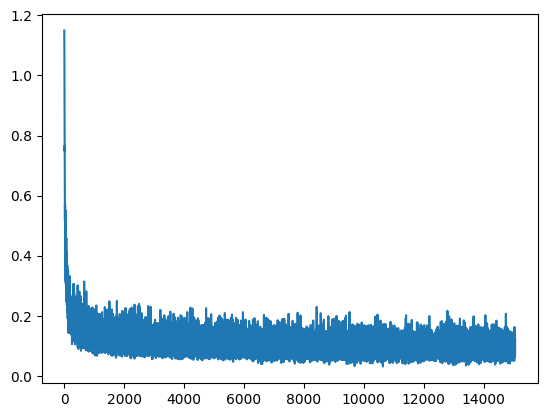

In [58]:
plt.plot(list(range(len(losses[:]))), losses[:])
plt.show()

In [25]:
@torch.no_grad() # since inference and not training
def generate_image():

  # start with a noisy image sample from N(0,I)
  x_t = torch.randn((1, 1, 28, 28)).to(device)

  model.eval()

  frames = []

  # iterative sampling to go from x_t to x_0
  for t in reversed(range(T)):
    z = torch.randn_like(x_t) if t > 0 else 0
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bars[t]
    factor = (1 - alpha_t)/torch.sqrt(1 - alpha_bar_t)
    var_t = torch.sqrt(betas[t]) # another complex option available
    t = torch.tensor([t]).to(device)
    x_t_minus_1 = (1/torch.sqrt(alpha_t))*(x_t - factor*model(x_t, t)) + var_t*z
    x_t = x_t_minus_1

    frames.append(x_t_minus_1.cpu().detach().numpy())

  return x_t_minus_1, frames # is actually x_0 after the last iteration

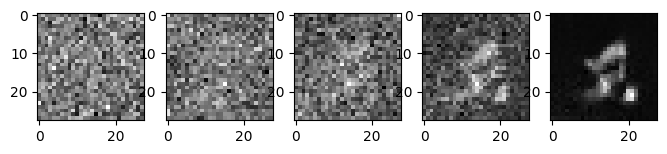

In [92]:
for i in range(1):
    op, frames = generate_image()

    fig = plt.figure(figsize=(8, 8))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        j = [0, 250, 500, 750, -1][i-1]
        img = frames[j][0,0]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
    plt.show()

In [77]:
torch.save(model.state_dict(), "simple.pt")

In [64]:
np.save("nine_2.npy", np.array(frames))

In [55]:

sum(p.numel() for p in SimpleNet().parameters() if p.requires_grad)

16867073